In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys

In [2]:
from wfOpto import *

pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'pandas'


In [3]:
from matplotlib.patches import Rectangle

In [4]:
import warnings
warnings.filterwarnings("ignore")

# goal: compare visual response to different LED frequencies
- given the rate of LED and its start time
- start with plotting the PSTH of V1 response for one mouse, 0-2 seconds
    - it may be easier to look at a handful of frequencies first rather than all 10
- find a "single value" way to quantify the extent of coherence
    - start with using amplitude. does the amplitude across the stimulus window correspond to the extent of coherence (qualitatively?)
- plot the amplitude vs oscillation rate
- compare this plot for different GCaMP lines

In [5]:
# load stimulus related files generated post-experiment
pdFlips = np.load(r'Z:\Subjects\ZYE_0069\2023-09-06\2\ledFlipTimes.npy').ravel()
flipRates = np.load(r'Z:\Subjects\ZYE_0069\2023-09-06\2\ledFreq.npy').ravel()

def findStimStartTimes():
    """
    This function takes in the photodiode flip times, which includes ALL
    times the light turned on and off (so not just the start of the stimulus).
    Taking advantage of the fact that stimuli are exactly 2 seconds long, we
    find the flip times that do correspond to the start of each stimulus.
    
    No input arguments - uses loaded files above.
    Returns:
        startTimes: array of the start time for each stimulus. e.g. if 
            there were 10 repetitions each of 5 different frequencies,
            this would be length (50, 1)
        stimFlips: array of the flip times within each stimulus. e.g.
            in the above example, it would be length (50, n), where
            n corresponds to the number of flips that occurred within
            the stimulus (and thus is not even across stimuli)
    """
    
    durationS = 2 # fixed?
    startTimes = []
    stimFlips = []
    
    thisStart = pdFlips[0]

    for stim in range(len(flipRates)):
        thisEnd = thisStart + durationS + 0.1
        try:
            nextStart = pdFlips[pdFlips > thisEnd][0] # set to first pd flip that is past the stim duration
        except:
            nextStart = None # should only happen at the end?
        startTimes.append(thisStart)
        
        flipIx = np.where((pdFlips >= thisStart) & (pdFlips <= thisEnd))
        flipTimes = pdFlips[flipIx]
        stimFlips.append(flipTimes)
        
        thisStart = nextStart
        
    startTimes = np.array(startTimes)
    stimFlips = np.array(stimFlips, dtype='object')
    return startTimes, stimFlips

In [6]:
startTimes, stimFlips = findStimStartTimes()

(635.0, 650.0)

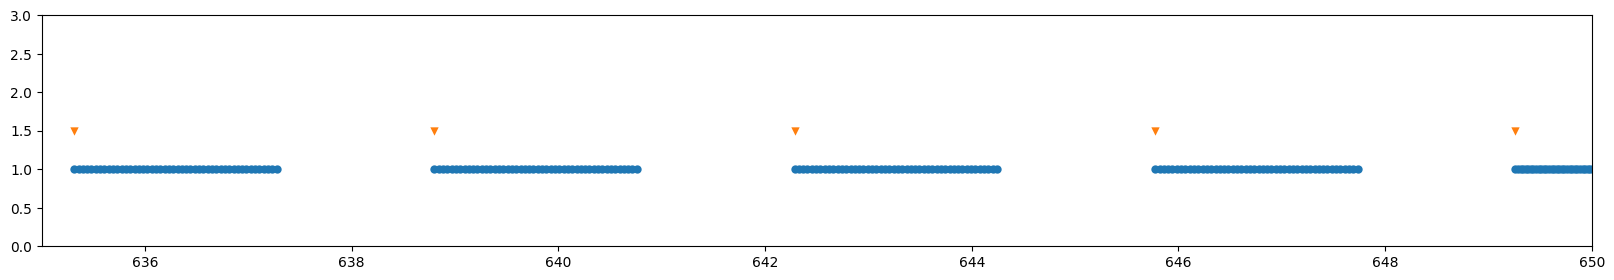

In [7]:
f = plt.figure(figsize=(20, 3))
plt.scatter(pdFlips, np.ones(len(pdFlips)), lw=0)
plt.scatter(startTimes, np.ones(len(startTimes))*1.5, marker='v', lw=0)
plt.ylim(0, 3)
plt.xlim(635, 650)

In [8]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-09-06\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]
meanImage = np.load(serverPath / 'blue/meanImage.npy')
px, py, ncomps = svdSpatFull.shape
svdSpat = svdSpatFull.reshape(px*py, ncomps)
tToWf = scipy.interpolate.interp1d(frameTimes, svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

In [9]:
stimFreqs = []
for stim in stimFlips:
    stimFreqs.append(len(stim))

In [10]:
print(np.unique(stimFreqs))

[  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120]


In [11]:
# create a graph for freq of 64 (32?) i guess

# indexes where the freq is x
index64 = [i for i,x in enumerate(stimFreqs) if x == 8]
#find startTimes where its x
startTimes64 = startTimes[index64]

In [12]:
allVideos = []
for time in startTimes64:
    trial_activity = tToWf(np.linspace(time,time+2,100))
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)
    
    video = spatial @ dwf
    video = video.reshape(560,560,-1)
    # video = np.mean(videoAvg, axis=2)
    
    allVideos.append(video)
    
allVideos = np.array(allVideos)

In [13]:
allVideos=np.mean(allVideos,axis=0)
print(allVideos.shape)

(560, 560, 100)


In [14]:
# plot pixel activity in this area? average a set of pixels
# plain ol pixel activity over timecourse
vc = np.mean(allVideos[380:500,120:220,:],axis=(0,1))
# vc = []
# for condition in allVideos:
#     trialAvgs=[]
#     trialAvgs = np.mean(condition[380:500, 120:220,:], axis=(0, 1))
#     vc.append(trialAvgs)
# vc = np.array(vc)

In [15]:
vc.shape

(100,)

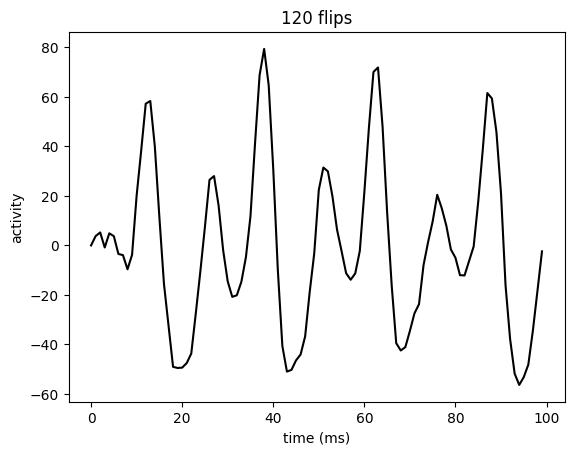

In [16]:
plt.plot(vc,color='black')
plt.xlabel('time (ms)')
plt.ylabel('activity')
plt.title('8?? flips')
plt.show()

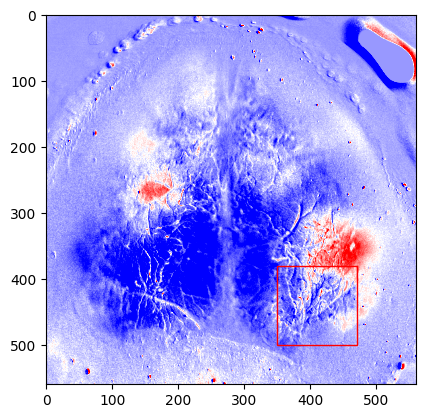

In [102]:
# n_col=5
# n_row=10
# f = plt.figure(figsize=(n_col*3, n_row*3))
# gs = mpl.gridspec.GridSpec(n_row, n_col)
# clim = np.percentile(allVideos,(2,99.9))

# for i in range(50):
#     ax = plt.subplot(gs[i])
#     brain=plt.imshow(video[:, :, i*2], clim = np.percentile(video, (2, 99.9)), cmap='bwr')
#     plt.colorbar(brain)

# f.tight_layout()

plt.imshow(video[:, :, i*2], clim = np.percentile(video, (2, 99.9)), cmap='bwr')
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((350,380),120,120,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

In [170]:
allVideos=[]
freqActivityLeft=[]
freqActivityRight=[]
# brain=[]
for count,freq in enumerate(np.unique(flipRates)):
    index = [i for i,x in enumerate(flipRates) if x == freq]
    startTimesFreq = startTimes[index]
    allVideos = []
    for time in startTimesFreq:
        trial_activity = tToWf(np.linspace(time,time+2,100))
        dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
        dwf = np.array(dwf)
    
        video = spatial @ dwf
        video = video.reshape(560,560,-1)
        
        allVideos.append(video)
        
    allVideos = np.array(allVideos)
    allVideos=np.mean(allVideos,axis=0) # average across the 30 repetitions of this particular stim
    
    # brain.append(np.mean(allVideos,axis=2)) # brain image for all 30 reps, all 100 time points - average activity during a rep
    
    vcLeft = np.mean(allVideos[380:500,120:220,:],axis=(0,1)) # left visual cortex
    freqActivityLeft.append(vcLeft)
    # vcRight = np.mean(allVideos[380:500,350:470,:],axis=(0,1)) # right visual cortex
    # freqActivityRight.append(vcRight)
    
freqActivityLeft=np.array(freqActivityLeft)
freqActivityRight=np.array(freqActivityRight)
# brain=np.array(brain)

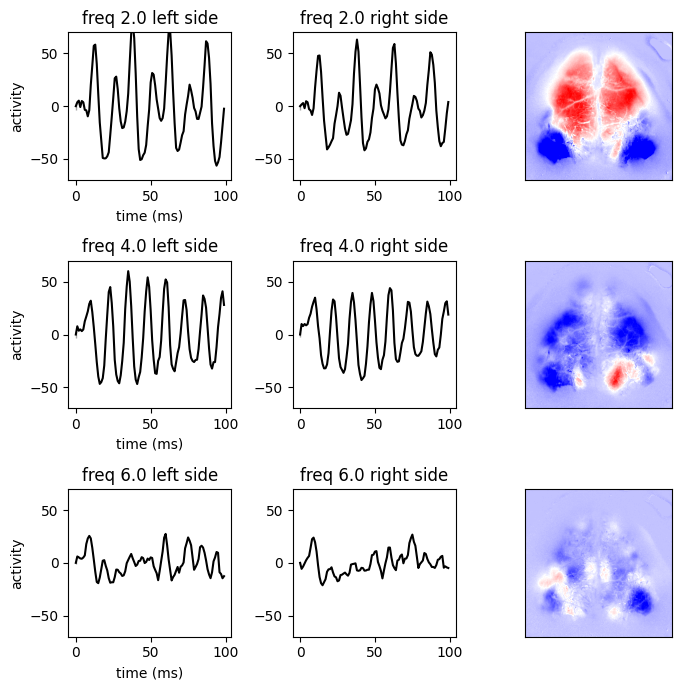

In [125]:
# n_col=2
# n_row=10
# f = plt.figure(figsize=(n_col*3, n_row*3))
# gs = mpl.gridspec.GridSpec(n_row, n_col)

fig, axs = plt.subplots(3,3,figsize=(7,7))

timestamps=np.arange(0,200,200,dtype=int)
clim = np.percentile(brain,(2,99.9))
for i,vc in enumerate(freqActivityLeft):
    axs[i,0].plot(vc,color='black')
    axs[i,0].fill_between(timestamps, \
                     np.mean(vc, axis=0)-scipy.stats.sem(vc,axis=0),\
                     np.mean(vc,axis=0)+scipy.stats.sem(vc,axis=0), color='darkgray', label='_nolegend_')
    axs[i,0].set_xlabel('time (ms)')
    axs[i,0].set_ylabel('activity')
    axs[i,0].set_ylim(top=70,bottom=-70)
    freq =np.unique(flipRates)[i]
    axs[i,0].set_title(f'freq {freq} left side')

    vcR=freqActivityRight[i]
    axs[i,1].plot(vcR,color='black')
    axs[i,1].fill_between(timestamps, \
                     np.mean(vcR, axis=0)-scipy.stats.sem(vcR,axis=0),\
                     np.mean(vcR,axis=0)+scipy.stats.sem(vcR,axis=0), color='darkgray', label='_nolegend_')
    # axs[i,1].set_xlabel('time (ms)')
    # axs[i,1].set_ylabel('activity')
    axs[i,1].set_ylim(top=70,bottom=-70)
    axs[i,1].set_title(f'freq {freq} right side')

    axs[i,2].imshow(brain[i],cmap='bwr',clim=clim)
    axs[i,2].set_xticks([])
    axs[i,2].set_yticks([])
    fig.tight_layout()

- find peak amplitude
- find number of times peak occurs
- true/expected = coherence metric?
- amp v coherence
- amp v true oscilaation with amp v expected oscilattion on same graph 

In [171]:
coherences=[]
binned_freqs=[]
maxAmps=[]
for i, vc in enumerate(freqActivityLeft):
    maxAmp = np.max(vc)
    maxAmps.append(maxAmp)
    freqs = [x for x in vc if ((x >=maxAmp-10) and (x<=maxAmp+10))]
    binned_freqs.append(freqs)
    count_freq = len(freqs)
    coherence = freq/np.unique(flipRates)[i]
    coherences.append(coherence)

In [169]:
freqActivityLeft[0]

array([  0.        ,   3.76735104,   5.24656093,  -0.82743901,
         4.89594834,   3.73636237,  -3.43687438,  -3.92390188,
        -9.61949407,  -3.79767068,  20.07636086,  38.26735839,
        57.26638862,  58.34065058,  39.96603049,  11.32809986,
       -15.47559221, -32.28694638, -49.04972968, -49.50858029,
       -49.37538034, -47.52619321, -43.67618663, -27.33145301,
       -10.33709927,   7.5610393 ,  26.49465499,  28.01840856,
        16.10885327,  -1.98699355, -14.51028101, -20.76878882,
       -20.13374439, -14.6788624 ,  -4.70968246,  11.89415447,
        41.25224792,  68.82000293,  79.39291882,  64.68495618,
        30.81769611,  -9.82792342, -40.67467355, -50.96767266,
       -50.2740884 , -46.44035033, -44.06928009, -36.74448354,
       -18.82801506,  -3.15102784,  22.45814339,  31.47644912,
        29.90341546,  19.78642601,   6.39133021,  -2.30101384,
       -11.23255998, -13.86094718, -11.31225816,  -2.23243203,
        21.50109529,  47.50401716,  70.08274232,  71.89

(0.0, 1.0)

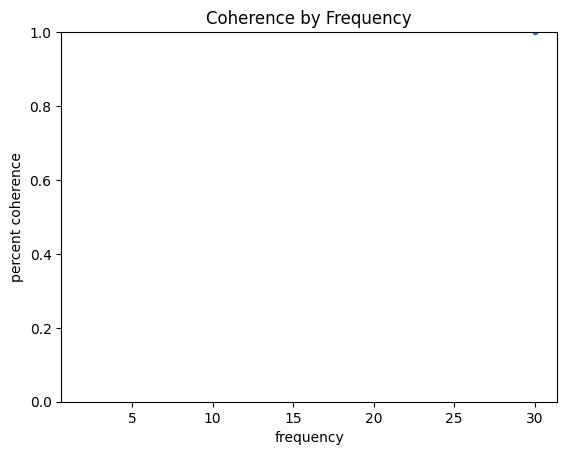

In [172]:
plt.plot(np.unique(flipRates),coherences,'-o',marker='.',linestyle='none')
plt.xlabel('frequency')
plt.ylabel('percent coherence')
plt.title('Coherence by Frequency')
plt.fill_between(np.unique(flipRates), \
                 np.mean(coherences, axis=0)-scipy.stats.sem(coherences,axis=0),\
                 np.mean(coherences,axis=0)+scipy.stats.sem(coherences,axis=0), color='lightblue')
plt.ylim(0,1)

In [142]:
np.unique(flipRates)

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
       28., 30.])

In [143]:
coherences

[0.5, 0.25, 0.3333333333333333]